1. Определить, является ли бэйстрэк сигналом или фоном
2. Сгруппировать бейстреки по ливням
3. Оценить порядковые номера этих ливней и расставить вероятности принадлежности бейстреков каждому из ливней

Продолжаем идею с предыдущего задания, плюс добавляется уровень сложности, связанный с разбиением ливней по кучкам

Разбиваем объем на последовательности и используем xgboost, в качестве фиг к которому идут фичи-последовательности.

modelgym - набор классов, который позволяет упростить подготовку к обучению параметров моделей параллельно или последовательно

Не надо знать, какие сигнальные, какие не сигнальные бэйстрэки, просто пользуемся осмысленной метрикой расстояния, которая учитывает расстояния и углы.
Алгоритмы пространственной индексации: KD-trees или Ball-trees

https://habrahabr.ru/post/312882/

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html

http://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors

Задача метрики расстояния: насобирать, несильно увеличивая размер выборки (остаться в пространстве осмысленного набора признаков), обучить классификатор. Т.е. переход от отдельных треков к парам не взорвет машину (все поместится в оперативную память)

data_ind - идентификатор кирпича

там несколько кирпичей

class_id - ливень

ливни внутри кирпича

принадлежность классу номер i считается по расстоянию вершины ливня до точки (0, 0, 0) в порядке увеличения этого расстояния

берем все начала ливней, считаем расстояние до начала координат, упорядочиваем

и номер в этом упорядоченном списке - номер класса (с 1, 0 - фон)

id,Usage,class_0,class_1 ... class_49, где class_0 -- шум. берутся первые 50 ближайших к центру кирпича ливни

центр определять как в файлике sort_by_distance

расстояние до ливня - расстояние до его вершины (самая маленькая по Z)

In [1]:
import pandas as pd
import numpy as np
import glob
from scipy.spatial import distance
from sklearn.neighbors import BallTree
import lightgbm as lgb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [111]:
train_data = pd.read_hdf('../ivanov.pub/data/dm5/open/open30.h5')

In [112]:
train_data.head()

,TX,TY,X,Y,Z,event_id,signal,data_ind
0,-0.043787,0.149312,37343.636719,57321.039062,25860.0,-999.0,0.0,21
1,-0.238449,-0.369275,38199.117188,14818.970703,72408.0,-999.0,0.0,21
2,0.312426,-0.253441,36330.500000,31390.966797,69822.0,-999.0,0.0,21
3,0.028330,-0.237798,43192.093750,46829.191406,18102.0,-999.0,0.0,21
4,0.318769,-0.355580,44290.164062,71907.625000,18102.0,-999.0,0.0,21


In [113]:
train_data.shape

(14881844, 8)

In [114]:
test_data = pd.read_csv('data/test_data13_changed_50.csv')
print(test_data.shape)
test_data.head()

(2958072, 7)


,id,TX,TY,X,Y,Z,data_ind
0,0,-0.243285,0.034970,49282.421875,49359.332031,40083.0,0
1,1,-0.111049,0.052493,41839.175781,21390.554688,33618.0,0
2,2,-0.047433,-0.269513,60404.886719,28631.410156,42669.0,0
3,3,-0.081808,0.022675,31875.050781,30950.125000,62064.0,0
4,4,0.386942,-0.271280,36173.644531,25627.705078,36204.0,0


In [115]:
answer_example = pd.read_csv("data/test_example13_changed_50.csv")
answer_example.head()

,id,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,...,class_40,class_41,class_42,class_43,class_44,class_45,class_46,class_47,class_48,class_49
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
train_data.data_ind.unique()

array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [117]:
train_data.event_id.unique().shape

(800,)

In [118]:
ind = train_data[train_data.data_ind == train_data.data_ind[0]]

In [119]:
ind.shape

(1508451, 8)

In [120]:
event_ids = ind.event_id.unique()
event_ids

array([  -999., 170362., 197662., 176366., 191841., 154158., 152241.,
       153536., 170554., 154329., 176143., 179701., 180951., 153168.,
       174047., 151169., 177778., 178131., 174814., 199159., 170161.,
       178476., 178851., 170512., 194322., 177363., 197394., 170351.,
       160568., 170621., 192637., 199277., 190553., 170369., 154201.,
       151804., 184507., 153972., 153049., 152007., 161292., 172053.,
       169631., 189765., 153491., 173457., 170065., 170323., 172838.,
       153683., 193407., 187991., 176195., 176974., 197287., 174503.,
       172708., 171061., 160337., 152290., 152189., 151597., 185838.,
       154747., 197162., 181546., 172854., 194190., 172092., 150989.,
       174558., 150787., 172881., 186047., 195269., 185958., 181010.,
       196748., 154004., 197496., 173649., 176029., 177495., 197457.,
       185974., 151465., 180613., 187857., 187223.])

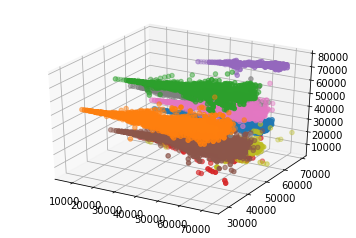

In [121]:
for event_id in ind.event_id.unique()[1:10]:
    ev = ind[ind.event_id == event_id]
    ax = plt.gca(projection='3d')
    ax.scatter3D(ev.Z, ev.X, ev.Y)

In [122]:
z = np.array(sorted(ind.Z.unique()))

In [123]:
z[1:] - z[:-1]

array([1.29300000e+03, 3.12582031e+02, 4.11328125e+00, 3.86718750e-01,
       1.63671875e+00, 7.38281250e-01, 9.73542969e+02, 2.97496094e+02,
       3.98437500e-01, 9.95105469e+02, 2.77636719e+02, 1.83593750e-01,
       8.00781250e-01, 5.07812500e-01, 1.01387109e+03, 2.55980469e+02,
       7.71484375e-01, 1.03624805e+03, 2.33664062e+02, 2.99023438e+00,
       2.02148438e+00, 1.05432422e+03, 2.14054688e+02, 2.22656250e+00,
       5.83984375e-01, 1.07613477e+03, 1.93753906e+02, 3.90625000e-02,
       1.09920703e+03, 1.74375000e+02, 1.07421875e+00, 1.72265625e+00,
       4.08203125e-01, 6.34765625e-01, 1.11478516e+03, 1.53287109e+02,
       1.03125000e+00, 3.71679688e+00, 1.13496484e+03, 1.34365234e+02,
       1.50390625e-01, 5.19531250e-01, 1.33203125e+00, 1.10742188e+00,
       9.98046875e-01, 1.88867188e+00, 6.25000000e-01, 1.15201367e+03,
       1.17128906e+02, 1.17587109e+03, 9.26699219e+01, 3.58203125e+00,
       1.56250000e+00, 5.03906250e-01, 2.42187500e-01, 1.19443945e+03,
      

In [124]:
(values, counts) = np.unique(z[1:] - z[:-1], return_counts=True)
index = np.argmax(counts)
dist = values[index]
print(dist)

1293.0


In [19]:
num_test_data_ind = len(test_data.data_ind.unique())

In [17]:
cols = ['X', 'Y', 'Z']
center = np.array([(ind[i].max() +  ind[i].min()) / 2 for i in cols])
center

array([50028.20703125, 40016.5625    , 36850.5       ])

In [21]:
distances = [[] for _ in range(num_test_data_ind)]
dst = []
dtype = [('ind', int), ('dst', float)]
for data_ind in range(num_test_data_ind):
    test_ind = test_data[test_data.data_ind == test_data.data_ind.unique()[data_ind]]
    origin_ids = []
    for row in test_ind.values:
        if not (row[5] / dist).is_integer():
            origin_ids.append(int(row[0]))
    center = np.array([(ind[i].max() +  ind[i].min()) / 2 for i in cols])
    for i in origin_ids:
        origin = test_ind.loc[i]
        origin_cords = [origin.X, origin.Y, origin.Z]
        distances[data_ind].append((i, distance.euclidean(origin_cords, center)))
    dst.append(np.array(distances[data_ind], dtype=dtype))
    dst[data_ind].sort(order='dst')

In [153]:
dst[0][:50]

array([( 779334,  7643.35451056), (1173376,  9622.2342714 ),
       (1238617, 11174.60959314), ( 651398, 11620.41509009),
       ( 450082, 12724.07497203), (1304805, 13150.54241229),
       ( 812877, 14296.75169101), (1327933, 14312.39124056),
       ( 942935, 14414.97186794), (   1187, 15138.123253  ),
       (   7662, 15550.65343539), ( 704442, 16370.58252027),
       ( 757781, 16544.29894703), ( 439491, 17645.90623265),
       ( 102346, 17758.7532428 ), ( 422679, 19203.58345988),
       (1166530, 19782.21030598), (1215124, 20003.69833427),
       (1384830, 20821.25824739), ( 684031, 21107.73560228),
       ( 671824, 22045.86195957), ( 803388, 22228.33788516),
       ( 164640, 22637.25644339), (1385912, 23273.46415638),
       ( 892366, 23365.6955094 ), ( 948611, 24483.98080645),
       ( 592748, 24551.67372716), (1086801, 24719.86993662),
       (1337490, 24909.61542356), ( 883395, 25202.94649893),
       (1443323, 25661.97189755), (1116611, 26784.37276591),
       (   3353, 26866.8

In [22]:
origin_ids = [[] for _ in range(num_test_data_ind)]
for data_ind in range(num_test_data_ind):
    for cls in range(49):
        origin_ids[data_ind].append(test_data.loc[dst[data_ind][cls][0]])

In [ ]:
class_dist = np.zeros((len(test_data), 49))
for i in range(len(test_data)):
    point = test_data.loc[i]
    data_ind = int(point.data_ind)
    for cls in range(49):
        origin = origin_ids[data_ind][cls]
        class_dist[i][cls] = distance.euclidean(
            [point.X, point.Y, point.Z], 
            [origin.X, origin.Y, origin.Z]
        )

In [28]:
class_dist[779334]

array([    0.        , 12590.60815552,  5594.06909374,  9099.42259672,
        5997.66323582, 17387.50831474, 15183.62722632, 16306.14935221,
       11978.27898872, 13380.12110922, 15639.14967143, 14100.34949479,
       10578.72243354, 10488.75742792, 18452.49688145, 19482.52268909,
       22203.18349575, 22013.348118  , 18972.26198603, 20914.13028808,
       24058.80243364, 16367.32242792, 16810.70167081, 16149.71542646,
       19077.18939922, 22425.76703726, 21704.13884348, 17180.96592459,
       26493.60569807, 27187.47686115, 27759.75564407, 19782.01965148,
       20595.01448346, 22168.83985365, 23216.2533035 , 21698.48505204,
       20272.50996849, 27480.55686768, 26981.48291759, 30393.61308087,
       27769.19755362, 29629.4117068 , 25923.94519444, 23382.21101949,
       31636.04680462, 28300.84837394, 26677.35085944, 25113.9773149 ,
       29309.84308747])

In [ ]:
probs = np.zeros((len(test_data), 49))
for i in range(len(class_dist)):
    summ = np.sum(class_dist[i])
    class_distt = 1 - (class_dist[i] / summ)
    summm = np.sum(class_distt)
    class_disttt = class_distt / summm
    minn = np.min(class_disttt)
    summmm = np.sum(class_disttt) + class_0[i] + 39 * minn
    probs[i] = class_disttt / summmm

In [16]:
columns = ['TX', 'TY', 'X', 'Y', 'Z']
cols_without_Z = columns[:-1]

In [17]:
def generate_pairs(df, k, same_pair, metric):
    pairs = []
    for data_ind in tqdm(df.data_ind.unique()):
        ind = df[df.data_ind == data_ind].copy()
        z_values = list(sorted(ind.Z.unique()))
        
        for z, z_next in zip(z_values, z_values[1:]):
            z, z_next = ind[ind.Z == z].copy(), ind[ind.Z == z_next].copy()
            z[['TX', 'TY']] *= dist
            z_next[['TX', 'TY']] *= dist
            
            bt = BallTree(z_next[cols_without_Z], metric=metric)
            dst, idx = bt.query(z[cols_without_Z], k=min(k, len(z_next)))
            
            for i in range(idx.shape[1]):
                data = z_next.iloc[idx[:, i]]
                temp = z.copy()
                for col in columns:
                    temp[col + '_pair'] = data[col].values
                if same_pair:
                    temp['same_pair'] = data.event_id.values == z.event_id.values
                pairs.append(temp)
            
        pairs.append(z_next)
        
    pairs = pd.concat(pairs)
    for col in columns:
        pairs['d' + col] = pairs[col].values - pairs[col + '_pair'].values
    return pairs

In [18]:
def make_train(df, k, metric):
    t = generate_pairs(df, k=k, same_pair=True, metric=metric)
    noise = t.event_id == -999
    signal, not_signal = t[~noise], t[noise]
    noise_part = not_signal.sample(len(signal))
    return pd.concat([signal, noise_part]).reset_index(drop=True)

In [126]:
train = []
train.append(make_train(train_data, k=3, metric='minkowski'))
train = pd.concat(train)

100%|██████████| 10/10 [01:30<00:00,  9.04s/it]
/home/lukanin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [127]:
train.head()

,TX,TX_pair,TY,TY_pair,X,X_pair,Y,Y_pair,Z,Z_pair,data_ind,event_id,same_pair,signal,dTX,dTY,dX,dY,dZ
0,37.176876,34.904358,57.802258,52.662411,36570.800781,36567.839844,37573.714844,37569.109375,1293.000000,1605.582031,21,170369.0,True,1.0,2.272518,5.139847,2.960938,4.605469,-312.582031
1,90.028969,34.904358,77.270569,52.662411,46962.492188,36567.839844,56969.125000,37569.109375,1293.000000,1605.582031,21,150989.0,False,1.0,55.124611,24.608158,10394.652344,19400.015625,-312.582031
2,-67.866905,34.904358,49.725986,52.662411,35590.781250,36567.839844,13027.308594,37569.109375,1293.000000,1605.582031,21,199277.0,False,1.0,-102.771263,-2.936424,-977.058594,-24541.800781,-312.582031
3,87.022667,34.904358,-55.483440,52.662411,34291.359375,36567.839844,34698.394531,37569.109375,1293.000000,1605.582031,21,197162.0,False,1.0,52.118309,-108.145851,-2276.480469,-2870.714844,-312.582031
4,34.904358,97.285156,52.662411,72.002357,36567.839844,46955.414062,37569.109375,56963.046875,1605.582031,1609.695312,21,170369.0,False,1.0,-62.380798,-19.339947,-10387.574219,-19393.937500,-4.113281


In [128]:
X_train = train.drop(['event_id', 'signal', 'data_ind', 'same_pair'], axis=1)
y_train = train.signal

In [129]:
lgb_train = lgb.Dataset(X_train, y_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_depth': 15,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 4
}

In [130]:
num_round = 100
bst = lgb.train(params, lgb_train, num_round)

In [131]:
test_pairs = generate_pairs(test_data, k=3, same_pair=False, metric='minkowski')

100%|██████████| 2/2 [00:17<00:00,  8.90s/it]
/home/lukanin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [132]:
X_test = test_pairs.drop(['data_ind'], axis=1).reset_index(drop=True)
X_test.head()

,TX,TX_pair,TY,TY_pair,X,X_pair,Y,Y_pair,Z,Z_pair,id,dTX,dTY,dX,dY,dZ
0,-186.590284,-222.138174,62.864187,91.196664,53888.816406,53427.371094,15242.111328,15439.837891,0.0,1293.0,18,35.547890,-28.332477,461.445312,-197.726562,-1293.0
1,37.303626,8.345815,705.521989,511.956824,56558.695312,57182.859375,37230.140625,37211.097656,0.0,1293.0,47,28.957811,193.565165,-624.164062,19.042969,-1293.0
2,318.728354,458.466642,-182.477507,-170.644247,57326.871094,57312.488281,39952.492188,39616.539062,0.0,1293.0,173,-139.738288,-11.833260,14.382812,335.953125,-1293.0
3,467.052954,81.437836,253.453021,-8.417969,44836.421875,44784.171875,74875.406250,75021.984375,0.0,1293.0,210,385.615118,261.870990,52.250000,-146.578125,-1293.0
4,-390.738074,-185.123163,-293.173802,25.434291,61861.617188,61895.531250,28830.445312,28622.546875,0.0,1293.0,328,-205.614911,-318.608093,-33.914062,207.898438,-1293.0


In [133]:
raw = pd.DataFrame(
    {'id': test_pairs.index, 'prob': bst.predict(X_test)}
).groupby('id').aggregate('mean')['prob']

In [134]:
class_0 = 1 - raw.astype('float16')

In [135]:
ans = pd.DataFrame(data={'id': raw.index, 'class_0': class_0})
ans.head()

,id,class_0
id,,
0,0,0.386719
1,1,0.451172
2,2,0.457520
3,3,0.400391
4,4,0.534668


In [136]:
classes = [f'class_{i}' for i in range(1, 50)]

In [ ]:
ans_prob = pd.DataFrame(data=probs, columns=classes)

In [ ]:
answer = pd.concat([ans, ans_prob], axis=1, sort=False)

In [471]:
for col in classes:
    answer[col] = answer[col].astype('float16')

In [424]:
answer.shape

(2958072, 51)

In [473]:
answer.head()

,id,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,...,class_40,class_41,class_42,class_43,class_44,class_45,class_46,class_47,class_48,class_49
id,,,,,,,,,,,,,,,,,,,,,
0,0,0.334961,0.009712,0.009727,0.009720,0.009727,0.009666,0.009659,0.009773,0.009628,...,0.009521,0.009521,0.009521,0.009514,0.009537,0.009636,0.009605,0.009613,0.009598,0.009506
1,1,0.400879,0.009399,0.009346,0.009377,0.009338,0.009422,0.009377,0.009308,0.009460,...,0.009369,0.009422,0.009476,0.009415,0.009369,0.009186,0.009209,0.009216,0.009239,0.009392
2,2,0.395508,0.009392,0.009415,0.009361,0.009369,0.009377,0.009476,0.009346,0.009468,...,0.009415,0.009377,0.009338,0.009399,0.009300,0.009293,0.009270,0.009254,0.009247,0.009377
3,3,0.576172,0.008667,0.008644,0.008667,0.008636,0.008667,0.008644,0.008659,0.008667,...,0.008614,0.008621,0.008652,0.008621,0.008598,0.008583,0.008568,0.008575,0.008583,0.008606
4,4,0.505371,0.008980,0.008911,0.008965,0.008926,0.009003,0.008926,0.008904,0.008995,...,0.008896,0.008942,0.009010,0.008934,0.008926,0.008781,0.008797,0.008812,0.008835,0.008911


In [472]:
answer.to_csv('data/submit20pn.csv', index=False)

In [49]:
answer.head()

,id,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,...,class_40,class_41,class_42,class_43,class_44,class_45,class_46,class_47,class_48,class_49
id,,,,,,,,,,,,,,,,,,,,,
0,0,0.437012,0.006397,0.006397,0.006397,0.006397,0.006397,0.006397,0.006397,0.006397,...,0.006397,0.006397,0.006397,0.006397,0.006397,0.006397,0.006397,0.006397,0.006397,0.006397
1,1,0.555176,0.005054,0.005054,0.005054,0.005054,0.005054,0.005054,0.005054,0.005054,...,0.005054,0.005054,0.005054,0.005054,0.005054,0.005054,0.005054,0.005054,0.005054,0.005054
2,2,0.493652,0.005959,0.005959,0.005959,0.005959,0.005959,0.005959,0.005959,0.005959,...,0.005959,0.005959,0.005959,0.005959,0.005959,0.005959,0.005959,0.005959,0.005959,0.005959
3,3,0.439453,0.006596,0.006596,0.006596,0.006596,0.006596,0.006596,0.006596,0.006596,...,0.006596,0.006596,0.006596,0.006596,0.006596,0.006596,0.006596,0.006596,0.006596,0.006596
4,4,0.711914,0.003389,0.003389,0.003389,0.003389,0.003389,0.003389,0.003389,0.003389,...,0.003389,0.003389,0.003389,0.003389,0.003389,0.003389,0.003389,0.003389,0.003389,0.003389


In [138]:
for col in tqdm(classes):
    answer[col] = (1 - class_0) / 88

100%|██████████| 49/49 [00:04<00:00, 10.40it/s]


In [168]:
cls = (1 - class_0[:1505447]) / 88

In [181]:
for col in tqdm(classes):
    answer[col] = cls

100%|██████████| 49/49 [00:02<00:00, 18.88it/s]


In [174]:
cls = (1 - class_0[1505447:]) / 85

In [181]:
for col in tqdm(classes):
    answer.loc[1505447:, col] = cls

100%|██████████| 49/49 [00:02<00:00, 18.88it/s]


In [470]:
for i in range(len(answer)):
    track_num = 88 if i < 1505447 else 85
    num = class_0[i] / track_num
    answer.iloc[i, 2:] = [num] * 49

In [189]:
answer.head()

,id,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,...,class_40,class_41,class_42,class_43,class_44,class_45,class_46,class_47,class_48,class_49
id,,,,,,,,,,,,,,,,,,,,,
0,0,0.386719,0.006969,0.006969,0.006969,0.006969,0.006969,0.006969,0.006969,0.006969,...,0.006969,0.006969,0.006969,0.006969,0.006969,0.006969,0.006969,0.006969,0.006969,0.006969
1,1,0.451172,0.006237,0.006237,0.006237,0.006237,0.006237,0.006237,0.006237,0.006237,...,0.006237,0.006237,0.006237,0.006237,0.006237,0.006237,0.006237,0.006237,0.006237,0.006237
2,2,0.457520,0.006165,0.006165,0.006165,0.006165,0.006165,0.006165,0.006165,0.006165,...,0.006165,0.006165,0.006165,0.006165,0.006165,0.006165,0.006165,0.006165,0.006165,0.006165
3,3,0.400391,0.006813,0.006813,0.006813,0.006813,0.006813,0.006813,0.006813,0.006813,...,0.006813,0.006813,0.006813,0.006813,0.006813,0.006813,0.006813,0.006813,0.006813,0.006813
4,4,0.534668,0.005287,0.005287,0.005287,0.005287,0.005287,0.005287,0.005287,0.005287,...,0.005287,0.005287,0.005287,0.005287,0.005287,0.005287,0.005287,0.005287,0.005287,0.005287


In [200]:
answers = answer.values
for row_id in range(len(answers)):
    for i in range(num_test_data_ind):
        for pair_id in range(49):
            if answers[row_id][0] == dst[i][pair_id][0]:
                answers[row_id][2:] = [0] * 49
                answers[row_id][2 + pair_id] = 1

In [206]:
answer = pd.DataFrame(data=answers, columns=['id', 'class_0']+classes)

In [209]:
answer.id = answerr.id.astype(int)

In [188]:
answer.to_csv('data/submit30.csv', index=False)

In [257]:
#80 
sum(answer.class_0 < 0.5)

415592

In [226]:
#70 0.40275
sum(answer.class_0 < 0.5)

482095

In [195]:
#60 
sum(answer.class_0 < 0.5)

367178

In [164]:
#50 
sum(answer.class_0 < 0.5)

398490

In [129]:
#40 
sum(answer.class_0 < 0.5)

418047

In [47]:
#10 0.41684
sum(answer.class_0 < 0.5)

477463

In [569]:
#30 0.37951 
sum(answer.class_0 < 0.5)

337638

In [ ]:
#30 0.37951 
sum(answer.class_0 < 0.5)

In [80]:
#20 0.39706
sum(answer.class_0 < 0.5)

363429